# Libraries

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
# %matplotlib widget    # interactive 3d plots
from sklearn.svm import SVC
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import data_loader
import model_evaluation
import plotting_utils
import model_training
from sklearn import linear_model
from sklearn import metrics
import copy
from mv_utils import lasso_rank, SVM_eval
# from tqdm import tqdm

/home/vrtx26/.local/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Feature (MFCC) extraction (Dataset generation)

In [3]:
# run this function if you need to generate a csv data set from scratch
X, y, ID = data_loader.load_dataset(should_generate_dataset=True, 
                                    use_vad=False, 
                                    use_delta_mfcc=False,
                                    use_delta_delta_mfcc=True)

{'ravdess': True, 'ravdess_speech': False, 'ravdess_song': False, 'tess': False}
INFO: n_fft=16384, n_mfcc=34
{'ravdess': True, 'ravdess_speech': False, 'ravdess_song': False, 'tess': False}


0it [00:00, ?it/s]

--- Data loaded. Loading time: 0.003998756408691406 seconds ---
X.shape =  (0, 0)
y.shape =  (0, 0)
ID.shape =  (0, 0)
data loaded in 0.010998964309692383ms
Empty DataFrame
Columns: []
Index: []
X.shape =  (0, 0)
X.columns =  Index([], dtype='object')


# Loading Dataset

In [2]:
X, y, ID = data_loader.load_dataset(X_path='data/2023-11-08/feature_mfcc_34_delta_delta_nfft_4096.csv', 
                                    y_path='data/2023-11-08/y_labels_feature_34_mfcc_delta_delta_nfft_4096.csv',
                                    ID_path='data/2023-11-08/IDs_feature_mfcc_34_delta_delta_nfft_4096.csv') 

data loaded in 0.1179206371307373ms
          0         1         2         3         4         5         6  \
0  0.327805 -0.464719 -0.540320 -0.983787 -1.276392 -0.517576 -0.059207   
1 -0.483202 -0.287426  0.073267 -0.259939 -1.043461  0.220426 -0.243781   
2 -0.982079  1.092156 -0.237941 -0.002997 -0.934974  0.313563  0.708375   
3  0.968642 -1.604765 -0.123183 -0.789169 -1.783557 -0.222486 -0.352760   
4  0.548607 -1.485735 -0.842989 -0.959707 -1.563772 -0.373401 -0.273213   

          7         8         9  ...       296       297       298       299  \
0 -1.325718 -0.865250 -1.400271  ... -0.000500  0.245232  0.467592  0.179897   
1 -0.745799 -0.558315 -0.667095  ...  0.081401 -0.156604  0.054227  1.335473   
2  0.392641 -0.112142 -0.675854  ...  1.159202 -0.281807  0.370446  0.969862   
3 -1.354752 -0.871037 -0.944073  ... -0.582348  1.606737 -1.213523  0.283672   
4 -1.374351 -0.530736 -0.333489  ... -0.312877 -1.016252 -0.713702  0.537837   

        300       301       302 

## Relabeling and normilizing

In [3]:
y_true = np.zeros((len(y)))
y_true[np.squeeze(y.values=='neutral')] = 1
y_true[y_true==0] = -1

X_data = X.values
X_norm = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)
y_reg = copy.copy(y_true)

# LASSO ranking

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.197e+02, tolerance: 3.584e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.195e+02, tolerance: 3.584e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.154e+02, tolerance: 3.584e-02

Text(0, 0.5, 'Coeffs')

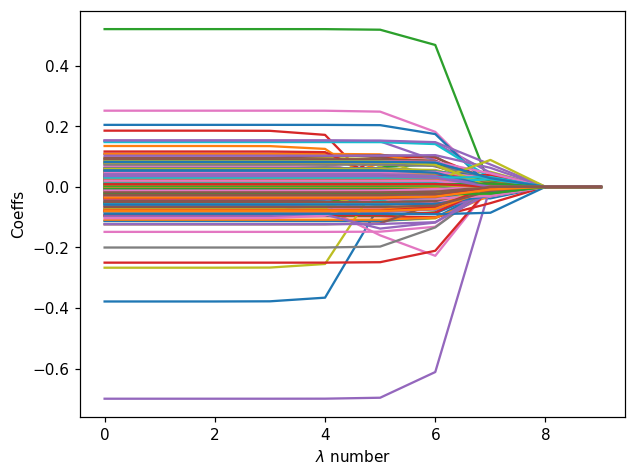

In [4]:

Lasso_model = linear_model.Lasso()
Npt = 10
coeffs = np.zeros((X_norm.shape[1],Npt))
lambda_ = np.logspace(-12.0, 0.5, Npt)
i = 0
for lamb in lambda_:
    Lasso_model = linear_model.Lasso(alpha=lamb, max_iter=20000)
    Lasso_model.fit(X_norm,y_reg)
    coeffs[:,i] = Lasso_model.coef_
    i = i + 1

plt.figure(dpi=110)
plt.plot(coeffs.T)
plt.xlabel('$\lambda$ number')
plt.ylabel('Coeffs')

In [5]:
Rank_lasso = []
for i in range(coeffs.shape[1]-1,-1,-1):
    withdraw_features = np.nonzero(coeffs[:,i])[0];
    something_new = np.setdiff1d(withdraw_features, Rank_lasso)
    if len(something_new):
        for ii in range(len(something_new)):
            Rank_lasso.append(something_new[ii])

In [6]:
np.save('data/Lasso_Ranking_neutral_result.npy', Rank_lasso)    # .npy extension is added if not given
Rank_lasso = np.load('data/Lasso_Ranking_neutral_result.npy')

# LOSO accuracy estimation

Iter =  1  AUC = 0.7608
Iter =  3  AUC = 0.7664
Iter =  4  AUC = 0.7801
Iter =  15  AUC = 0.7935
Iter =  27  AUC = 0.7972
Iter =  28  AUC = 0.7987
Iter =  29  AUC = 0.8002
Iter =  37  AUC = 0.8151
Iter =  49  AUC = 0.8173
Iter =  67  AUC = 0.8348
Iter =  68  AUC = 0.8400
auc_best = 0.84002976


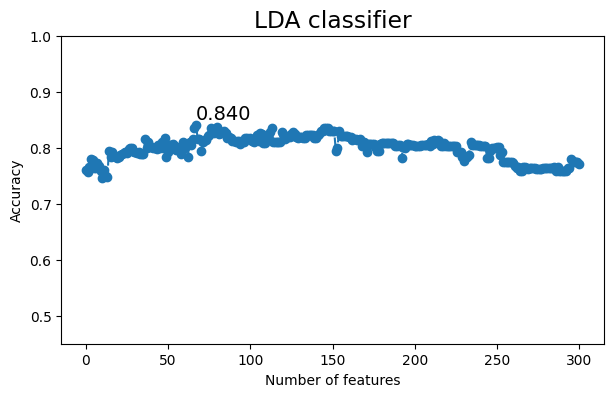

In [7]:
# Rank = lasso_rank(X,y)
# Rank = np.array(Rank)

# subj_IDs = np.squeeze(ID.values)

Rank = Rank_lasso
auc_svm = []
auc_best = 0
ind_best = 0
for k in range(1,len(Rank)+1):
    feature_inds = Rank[:k]
    auc = SVM_eval(X_norm,y_reg, feature_inds, ID)    
    auc_svm.append(auc)
    if (auc>auc_best):
        auc_best = auc
        ind_best = k-1
        print('Iter = ', k, f' AUC = {auc:.4f}' )
    
fig,ax=plt.subplots(figsize=(7,4),dpi=100)
plt.rcParams.update({'font.size': 14})
plt.plot(auc_svm,marker='o', linestyle='dashed')
plt.text(ind_best, auc_best+0.01, f'{auc_best:.3f}')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('LDA classifier')
plt.ylim([0.45, 1.00])

print(f'auc_best = {auc_best:.8f}')

# image_name = 'figures\\ACC_LDA_vowel_a.jpg'
# fig.savefig(image_name, bbox_inches='tight', pad_inches = 0.2)

In [8]:
print('best auc (LDA) = ', np.max(auc_svm), 'Number of features = ', np.argmax(auc_svm))

best auc (LDA) =  0.8400297619047619 Number of features =  67


# Backward step selection

In [9]:
def back_step_selection_loso(X,y,feature_ind, ID):
# BACK_STEP_SELECTION Automatic procedure of feature selection

#basic version
   acc_mu_curr = SVM_eval(X,y,feature_ind, ID)
   some_feature_droped = True
   while (some_feature_droped):
      print('NEW ROUND')
      acc_up = -np.ones_like(feature_ind)
      for i in range(len(feature_ind)):
         cur_inds = np.setdiff1d(feature_ind,feature_ind[i])
         acc_mu = SVM_eval(X,y,cur_inds, ID)
         
         print(f'Iter #{i}: {acc_mu:.3f} <-> {acc_mu_curr:.3f}')
         
         if (acc_mu>=acc_mu_curr):
            acc_up[i] = acc_mu-acc_mu_curr
      m_val = np.max(acc_up)
      m_ind = np.argmax(acc_up)
      
      if (m_val>=0):
         print(f'Withdraw feature #{m_ind}, added accracy {m_val}')
         feature_ind = np.setdiff1d(feature_ind,feature_ind[m_ind]);
         some_feature_droped = True       
         # new basic version
         acc_mu_curr = SVM_eval(X,y,feature_ind, ID)
      else:
         acc_final = acc_mu_curr
         some_feature_droped = False

   return acc_final, feature_ind

In [10]:
ind_best = np.argmax(auc_svm)
[acc_final,feature_ind] = back_step_selection_loso(X_norm, y_reg, Rank[:ind_best+1],ID)

NEW ROUND
Iter #0: 0.794 <-> 0.840
Iter #1: 0.839 <-> 0.840
Iter #2: 0.840 <-> 0.840
Iter #3: 0.821 <-> 0.840
Iter #4: 0.839 <-> 0.840
Iter #5: 0.840 <-> 0.840
Iter #6: 0.845 <-> 0.840
Iter #7: 0.843 <-> 0.840
Iter #8: 0.793 <-> 0.840
Iter #9: 0.837 <-> 0.840
Iter #10: 0.802 <-> 0.840
Iter #11: 0.834 <-> 0.840
Iter #12: 0.840 <-> 0.840
Iter #13: 0.832 <-> 0.840
Iter #14: 0.846 <-> 0.840
Iter #15: 0.804 <-> 0.840
Iter #16: 0.838 <-> 0.840
Iter #17: 0.794 <-> 0.840
Iter #18: 0.805 <-> 0.840
Iter #19: 0.839 <-> 0.840
Iter #20: 0.796 <-> 0.840
Iter #21: 0.844 <-> 0.840
Iter #22: 0.840 <-> 0.840
Iter #23: 0.838 <-> 0.840
Iter #24: 0.816 <-> 0.840
Iter #25: 0.816 <-> 0.840
Iter #26: 0.808 <-> 0.840
Iter #27: 0.844 <-> 0.840
Iter #28: 0.838 <-> 0.840
Iter #29: 0.839 <-> 0.840
Iter #30: 0.844 <-> 0.840
Iter #31: 0.812 <-> 0.840
Iter #32: 0.845 <-> 0.840
Iter #33: 0.799 <-> 0.840
Iter #34: 0.823 <-> 0.840
Iter #35: 0.839 <-> 0.840
Iter #36: 0.829 <-> 0.840
Iter #37: 0.797 <-> 0.840
Iter #38: 0.

Iter #44: 0.845 <-> 0.846
Iter #45: 0.805 <-> 0.846
Iter #46: 0.840 <-> 0.846
Iter #47: 0.814 <-> 0.846
Iter #48: 0.838 <-> 0.846
Iter #49: 0.838 <-> 0.846
Iter #50: 0.841 <-> 0.846
Iter #51: 0.841 <-> 0.846
Iter #52: 0.844 <-> 0.846
Iter #53: 0.834 <-> 0.846
Iter #54: 0.846 <-> 0.846
Iter #55: 0.822 <-> 0.846
Iter #56: 0.848 <-> 0.846
Iter #57: 0.852 <-> 0.846
Iter #58: 0.852 <-> 0.846
Iter #59: 0.820 <-> 0.846
Iter #60: 0.839 <-> 0.846
Iter #61: 0.831 <-> 0.846
Iter #62: 0.815 <-> 0.846
Iter #63: 0.844 <-> 0.846
Withdraw feature #1, added accracy 0
NEW ROUND
Iter #0: 0.816 <-> 0.846
Iter #1: 0.830 <-> 0.846
Iter #2: 0.851 <-> 0.846
Iter #3: 0.852 <-> 0.846
Iter #4: 0.795 <-> 0.846
Iter #5: 0.829 <-> 0.846
Iter #6: 0.852 <-> 0.846
Iter #7: 0.808 <-> 0.846
Iter #8: 0.841 <-> 0.846
Iter #9: 0.840 <-> 0.846
Iter #10: 0.803 <-> 0.846
Iter #11: 0.846 <-> 0.846
Iter #12: 0.847 <-> 0.846
Iter #13: 0.819 <-> 0.846
Iter #14: 0.840 <-> 0.846
Iter #15: 0.802 <-> 0.846
Iter #16: 0.839 <-> 0.846
I

Iter #42: 0.856 <-> 0.857
Iter #43: 0.845 <-> 0.857
Iter #44: 0.851 <-> 0.857
Iter #45: 0.853 <-> 0.857
Iter #46: 0.853 <-> 0.857
Iter #47: 0.841 <-> 0.857
Iter #48: 0.819 <-> 0.857
Iter #49: 0.828 <-> 0.857
Iter #50: 0.834 <-> 0.857
Iter #51: 0.859 <-> 0.857
Iter #52: 0.830 <-> 0.857
Iter #53: 0.821 <-> 0.857
Iter #54: 0.827 <-> 0.857
Iter #55: 0.855 <-> 0.857
Iter #56: 0.844 <-> 0.857
Iter #57: 0.802 <-> 0.857
Iter #58: 0.858 <-> 0.857
Withdraw feature #8, added accracy 0
NEW ROUND
Iter #0: 0.808 <-> 0.857
Iter #1: 0.818 <-> 0.857
Iter #2: 0.866 <-> 0.857
Iter #3: 0.838 <-> 0.857
Iter #4: 0.839 <-> 0.857
Iter #5: 0.818 <-> 0.857
Iter #6: 0.842 <-> 0.857
Iter #7: 0.817 <-> 0.857
Iter #8: 0.834 <-> 0.857
Iter #9: 0.851 <-> 0.857
Iter #10: 0.815 <-> 0.857
Iter #11: 0.832 <-> 0.857
Iter #12: 0.858 <-> 0.857
Iter #13: 0.850 <-> 0.857
Iter #14: 0.825 <-> 0.857
Iter #15: 0.844 <-> 0.857
Iter #16: 0.851 <-> 0.857
Iter #17: 0.856 <-> 0.857
Iter #18: 0.857 <-> 0.857
Iter #19: 0.854 <-> 0.857
I

Iter #10: 0.826 <-> 0.875
Iter #11: 0.820 <-> 0.875
Iter #12: 0.844 <-> 0.875
Iter #13: 0.867 <-> 0.875
Iter #14: 0.870 <-> 0.875
Iter #15: 0.847 <-> 0.875
Iter #16: 0.823 <-> 0.875
Iter #17: 0.881 <-> 0.875
Iter #18: 0.858 <-> 0.875
Iter #19: 0.824 <-> 0.875
Iter #20: 0.834 <-> 0.875
Iter #21: 0.817 <-> 0.875
Iter #22: 0.826 <-> 0.875
Iter #23: 0.844 <-> 0.875
Iter #24: 0.813 <-> 0.875
Iter #25: 0.857 <-> 0.875
Iter #26: 0.876 <-> 0.875
Iter #27: 0.850 <-> 0.875
Iter #28: 0.835 <-> 0.875
Iter #29: 0.805 <-> 0.875
Iter #30: 0.874 <-> 0.875
Iter #31: 0.843 <-> 0.875
Iter #32: 0.858 <-> 0.875
Iter #33: 0.868 <-> 0.875
Iter #34: 0.863 <-> 0.875
Iter #35: 0.832 <-> 0.875
Iter #36: 0.869 <-> 0.875
Iter #37: 0.851 <-> 0.875
Iter #38: 0.834 <-> 0.875
Iter #39: 0.824 <-> 0.875
Iter #40: 0.835 <-> 0.875
Iter #41: 0.838 <-> 0.875
Iter #42: 0.840 <-> 0.875
Iter #43: 0.844 <-> 0.875
Iter #44: 0.790 <-> 0.875
Iter #45: 0.802 <-> 0.875
Iter #46: 0.875 <-> 0.875
Iter #47: 0.844 <-> 0.875
Iter #48: 0.

In [11]:
np.save('data/feature_idx_neutral.npy', feature_ind)    # .npy extension is added if not given
feature_ind = np.load('data/feature_idx_neutral.npy')

# 5-fold CV (full feature space)

In [12]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm)
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

## GridSearch

 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.90it/s]

UAR = 0.391


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.48it/s]

UAR = 0.419


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.17it/s]

UAR = 0.419


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.20it/s]

UAR = 0.436


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.94it/s]

UAR = 0.456


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.16it/s]

UAR = 0.454


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.88it/s]

UAR = 0.444


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.34it/s]

UAR = 0.436


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.66it/s]

UAR = 0.429


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


UAR = 0.423
UAR_best = 0.456, C_best = 0.004


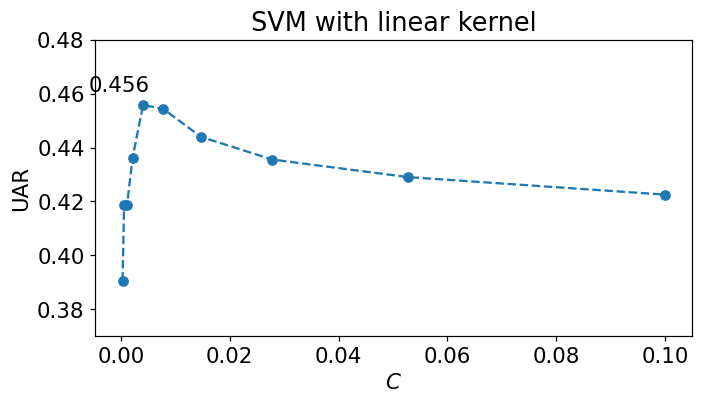

In [13]:
C = np.logspace(-3.5, -1.0, 10, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)

# fig,ax=plt.subplots(figsize=(7,3.5))
# plt.rcParams.update({'font.size': 14})
# plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.ylim([0.37, 0.45])
# plt.xlabel('C')
# plt.ylabel('UAR')

fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) # 
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
# plt.xlabel('$\log_{10}(C)$')
plt.xlabel('$C$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')

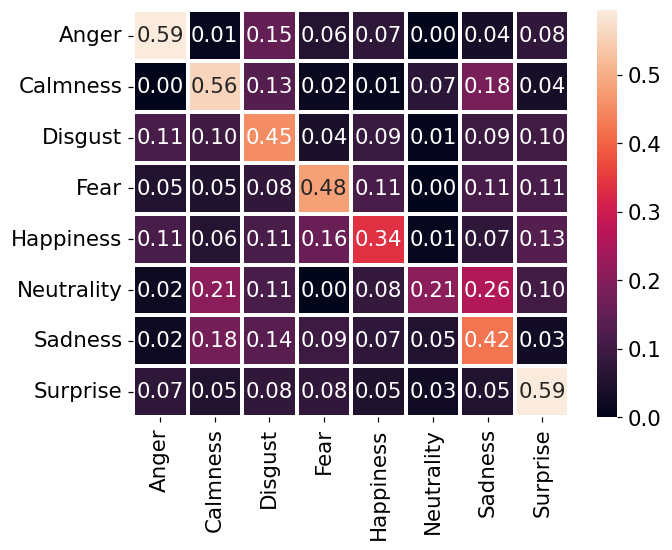

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [14]:
# Confusion matrix
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)

# 5-fold CV (selected feature space)

In [15]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm[:,feature_ind])
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

In [16]:
X_new

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.327919,0.172226,1.972389,0.507975,1.136402,3.253256,0.827516,1.395033,-0.527543,0.176481,...,-0.134175,-0.803406,-0.412461,0.697438,-1.195752,1.077390,-0.839432,1.533704,1.841825,1.463552
1,-0.483370,0.613144,0.647493,-0.578013,0.712442,1.911722,-1.320254,0.097127,1.761002,-0.255397,...,-0.384878,-0.229401,-0.006407,-0.809363,-0.276979,-0.198047,-0.515657,-0.034422,-0.533340,-0.068275
2,-0.982420,0.981156,0.152506,-0.276989,0.594105,1.161570,-0.790393,-0.270297,0.082329,0.127939,...,0.685220,-1.340559,-0.618141,-0.330014,-0.823537,-0.340606,-0.161582,-0.980633,-0.602932,-0.508076
3,0.968978,-0.562788,1.409404,0.540148,0.547577,2.585998,-0.305098,1.052833,0.107714,-0.201216,...,0.561642,0.059512,0.141096,-0.948128,-1.134027,-0.655636,-0.065243,0.242407,-1.413805,0.906458
4,0.548798,0.343931,1.757624,1.195381,0.859079,3.082187,1.680597,3.622435,-0.365790,0.746405,...,1.999628,-1.493871,-0.439787,1.162407,-1.012739,-0.269781,-0.400117,0.420669,-0.537256,1.819556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.137958,0.995423,-0.402387,1.267308,1.929130,-0.068379,0.637919,0.566415,0.126003,0.129546,...,0.991508,1.734500,-0.499437,0.974451,1.049207,1.785393,-1.151167,0.132503,1.585598,1.597194
1436,1.705626,-0.063867,0.399012,1.304799,-0.514948,0.593122,2.429269,1.044760,-0.249330,0.941597,...,1.087294,-0.070141,0.081307,2.646820,1.745137,-1.404305,-0.500354,-0.364632,0.767564,0.060126
1437,0.619210,0.205071,-0.567749,1.806541,-0.014449,0.221267,0.640135,0.996080,-0.207775,0.302507,...,1.178085,1.270279,0.236277,1.148263,-0.167680,-0.486382,-0.443740,0.780604,1.035466,1.555189
1438,-0.363270,1.012529,0.113842,0.129659,0.708992,-0.560947,-0.435340,0.540462,-0.655802,-0.487100,...,0.512360,1.083050,-0.615214,0.130952,-1.023055,-1.447142,-0.442472,0.503808,-0.851576,-0.481803


## GridSearch

 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.55it/s]

UAR = 0.306


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.30it/s]

UAR = 0.309


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.01it/s]

UAR = 0.316


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.47it/s]

UAR = 0.339


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.13it/s]

UAR = 0.358


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.95it/s]

UAR = 0.363


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.13it/s]

UAR = 0.370


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.81it/s]

UAR = 0.372


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.79it/s]

UAR = 0.386


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.40it/s]

UAR = 0.392


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.72it/s]

UAR = 0.393


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.57it/s]

UAR = 0.394


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.79it/s]

UAR = 0.398


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.26it/s]

UAR = 0.404


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.41it/s]

UAR = 0.403


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.79it/s]

UAR = 0.402


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.00it/s]

UAR = 0.410


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.44it/s]

UAR = 0.410


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.13it/s]

UAR = 0.409


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.98it/s]

UAR = 0.402


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 23.01it/s]

UAR = 0.398


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 23.10it/s]

UAR = 0.400


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 22.98it/s]

UAR = 0.401


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.63it/s]

UAR = 0.402


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.81it/s]

UAR = 0.391


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.00it/s]

UAR = 0.392


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.96it/s]

UAR = 0.387


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 20.00it/s]

UAR = 0.394


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.76it/s]

UAR = 0.398


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.36it/s]

UAR = 0.395


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.39it/s]

UAR = 0.395


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.57it/s]

UAR = 0.389


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.52it/s]

UAR = 0.381


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 11.54it/s]

UAR = 0.383


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.81it/s]

UAR = 0.372


  0%|                                                                                                                                                                                                | 0/5 [00:00<?, ?it/s]

UAR = 0.374


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.99it/s]

UAR = 0.372


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.47it/s]

UAR = 0.372


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  5.66it/s]

UAR = 0.371


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


UAR = 0.371
UAR_best = 0.410, C_best = 0.011


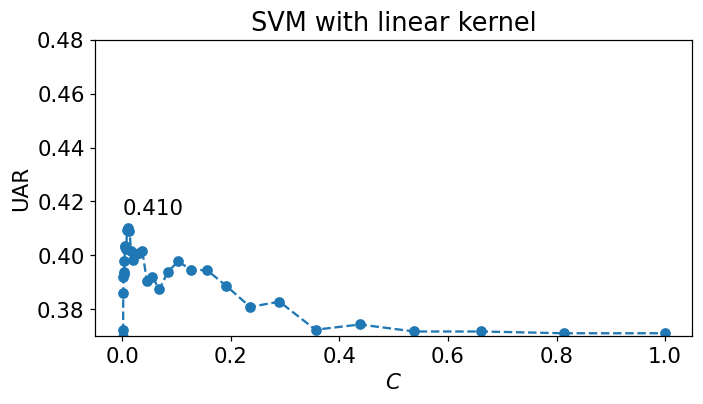

In [17]:
C = np.logspace(-3.5, -0.0, 40, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)

fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) 
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
# plt.xlabel('$\log_{10}(C)$')
plt.xlabel('$C$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')

## Confusion matrix

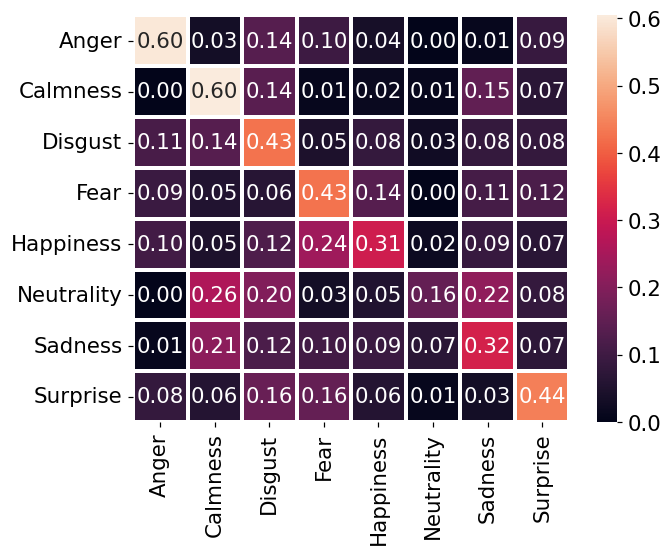

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [19]:
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)